In [11]:
# Desde 1 enero del 2020 hasta 31 enero del 2024

In [12]:
import yfinance as yf

#Descarga de datos de Yahoo Finance

aapl_data = yf.download('UBER', start='2020-01-01', end='2024-01-31')

/home/albertocastrovill/Documents/UDEM/IA2/IA2_venv/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [13]:
# Imprimir los primeros 5 registros
print(aapl_data.head())


                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-01-02  29.940001  31.000000  29.790001  30.990000  30.990000  20578900
2020-01-03  30.620001  31.430000  30.480000  31.370001  31.370001  18822700
2020-01-06  31.010000  32.060001  31.000000  31.580000  31.580000  21204700
2020-01-07  31.790001  32.840000  31.360001  32.810001  32.810001  30119600
2020-01-08  32.730000  34.520000  32.459999  33.930000  33.930000  43944400


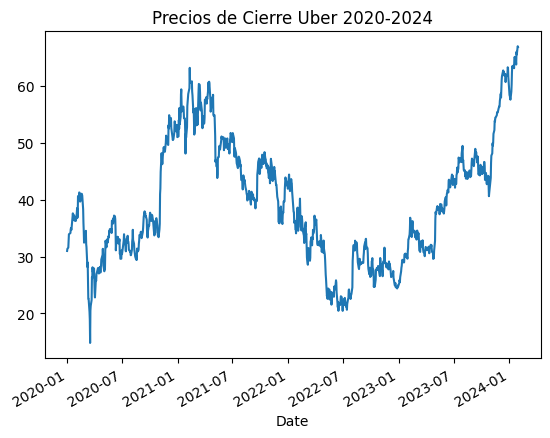

In [14]:
import matplotlib.pyplot as plt

close_prices = aapl_data['Close']
close_prices.plot()
plt.title('Precios de Cierre Uber 2020-2024')
plt.show()

In [15]:
# Realizamos el test de Dickey-Fuller aumentado para comprobar si la serie es estacionaria
from statsmodels.tsa.stattools import adfuller

result = adfuller(close_prices)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] < 0.05:
    print('La serie es estacionaria (no tiene tendencia)')
else:
    print('La serie no es estacionaria (tiene tendencia)')




ADF Statistic: -1.258199
p-value: 0.648073
La serie no es estacionaria (tiene tendencia)


In [16]:
# Hayamos la primera diferencia de la serie

diff = close_prices.diff().dropna()

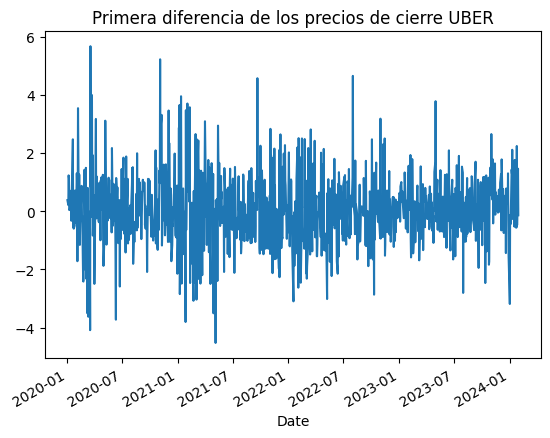

In [17]:
# Graficamos la primera diferencia
diff.plot()
plt.title('Primera diferencia de los precios de cierre UBER')
plt.show()


In [18]:
test_diff = adfuller(diff)
print('ADF Statistic: %f' % test_diff[0])
print('p-value: %f' % test_diff[1])

if test_diff[1] < 0.05:
    print('La serie es estacionaria (no tiene tendencia)')
else:
    print('La serie no es estacionaria (tiene tendencia)')
    

ADF Statistic: -20.770277
p-value: 0.000000
La serie es estacionaria (no tiene tendencia)


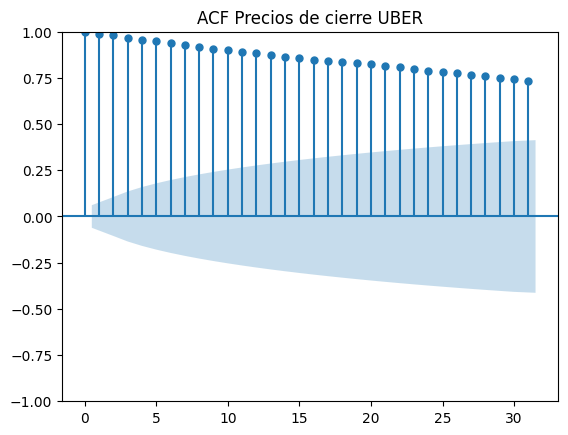

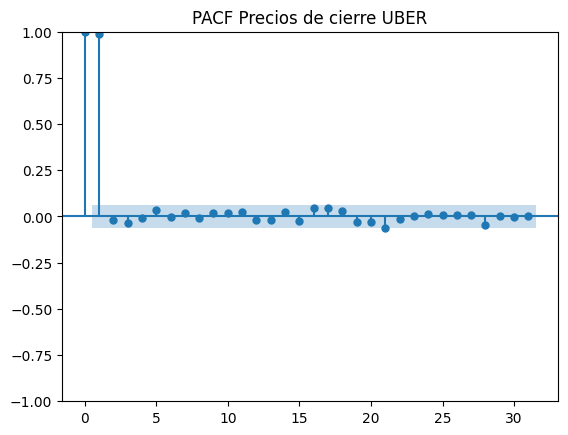

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficamos la función de autocorrelación
plot_acf(close_prices.dropna())
plt.title('ACF Precios de cierre UBER')
plt.show()

# Graficamos la función de autocorrelación parcial
plot_pacf(close_prices.dropna())
plt.title('PACF Precios de cierre UBER')
plt.show()

In [20]:
import warnings 
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Desactivamos los mensajes de advertencia
warnings.filterwarnings("ignore")

#Generamos la funcion optima
def optimal_d(series):
  d=0
  p_value=adfuller(series)[1]
  while p_value > 0.05:
    d += 1
    p_value = adfuller(np.diff(series,n=d))[1]
  return d

d_optimal = optimal_d(close_prices)

#funcion para evaluar AR I MA

def evaluar_modelo(dataset, p_values, d, q_values):
  dataset = dataset.astype("float32")
  best_score , best_cf = float("inf"), None
  for p in p_values:
    for q in q_values:
      order = (p,d,q)
      try: 
        model = ARIMA(dataset, order=order)
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_score:
          best_score, best_cf = aic, order
        print("ARIMA%s AIC%.3f" %(order,aic))
      except: 
        continue
  print("BEST MODEL: ARIMA%s AIC%.3f" %(best_cf, best_score))
  return best_cf

#rangos de valores para p y q
p_values = range(0,5)
d_values = range(0,3)

#evaluamos el modelo
best_order = evaluar_modelo(close_prices, p_values, d_optimal, p_values)
print(f"Los mejores valores para el modelo ARIMA son: p={best_order[0]}, d={d_optimal}, q={best_order[2]}")

ARIMA(0, 1, 0) AIC3326.909
ARIMA(0, 1, 1) AIC3328.563
ARIMA(0, 1, 2) AIC3324.726
ARIMA(0, 1, 3) AIC3326.668
ARIMA(0, 1, 4) AIC3328.651
ARIMA(1, 1, 0) AIC3328.512
ARIMA(1, 1, 1) AIC3328.765
ARIMA(1, 1, 2) AIC3326.676
ARIMA(1, 1, 3) AIC3328.725
ARIMA(1, 1, 4) AIC3328.928
ARIMA(2, 1, 0) AIC3324.821
ARIMA(2, 1, 1) AIC3326.819
ARIMA(2, 1, 2) AIC3328.630
ARIMA(2, 1, 3) AIC3328.559
ARIMA(2, 1, 4) AIC3330.893
ARIMA(3, 1, 0) AIC3326.816
ARIMA(3, 1, 1) AIC3328.816
ARIMA(3, 1, 2) AIC3328.466
ARIMA(3, 1, 3) AIC3330.444
ARIMA(3, 1, 4) AIC3332.485
ARIMA(4, 1, 0) AIC3328.523
ARIMA(4, 1, 1) AIC3328.639
ARIMA(4, 1, 2) AIC3330.357
ARIMA(4, 1, 3) AIC3329.253
ARIMA(4, 1, 4) AIC3325.276
BEST MODEL: ARIMA(0, 1, 2) AIC3324.726
Los mejores valores para el modelo ARIMA son: p=0, d=1, q=2


In [21]:
from statsmodels.tsa.arima.model import ARIMA

#Ajustamos el modelo elegido
model = ARIMA(close_prices, order=(0,1,0))
model_fit = model.fit()

#Resumen
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1026
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1662.454
Date:                Thu, 15 Feb 2024   AIC                           3326.909
Time:                        11:37:11   BIC                           3331.841
Sample:                             0   HQIC                          3328.781
                               - 1026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.5007      0.049     30.320      0.000       1.404       1.598
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               114.06
Prob(Q):                              0.54   Pr

In [22]:
#Predicciones
arima_predicciones = model_fit.forecast(steps=15)
print(arima_predicciones)

1026    66.839996
1027    66.839996
1028    66.839996
1029    66.839996
1030    66.839996
1031    66.839996
1032    66.839996
1033    66.839996
1034    66.839996
1035    66.839996
1036    66.839996
1037    66.839996
1038    66.839996
1039    66.839996
1040    66.839996
Name: predicted_mean, dtype: float64


In [23]:
# Creamos la Red Neuronal
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalizamos los datos
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.array(close_prices).reshape(-1,1))

# Generamos la secuencia
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X,y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0],X.shape[1],1)

In [24]:
#Cremos el modelo LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

#Constriur el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))

model.add(Dense(1)) #Capa de salida unica

#Compilamos el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

2024-02-15 11:37:12.337769: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 11:37:12.584846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 11:37:12.584957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 11:37:12.613869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 11:37:12.687327: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 11:37:12.688542: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [25]:
#Entrenamos el modelo
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
model.fit(X, y, epochs=80, batch_size=32, callbacks=[early_stop])

Epoch 1/80
29/29 [==============================] - 7s 73ms/step - loss: 0.0475
Epoch 2/80
29/29 [==============================] - 2s 70ms/step - loss: 0.0059
Epoch 3/80
29/29 [==============================] - 2s 67ms/step - loss: 0.0033
Epoch 4/80
29/29 [==============================] - 2s 66ms/step - loss: 0.0029
Epoch 5/80
29/29 [==============================] - 2s 70ms/step - loss: 0.0028
Epoch 6/80
29/29 [==============================] - 2s 65ms/step - loss: 0.0027
Epoch 7/80
29/29 [==============================] - 2s 68ms/step - loss: 0.0026
Epoch 8/80
29/29 [==============================] - 2s 65ms/step - loss: 0.0026
Epoch 9/80
29/29 [==============================] - 2s 66ms/step - loss: 0.0025
Epoch 10/80
29/29 [==============================] - 2s 67ms/step - loss: 0.0024
Epoch 11/80
29/29 [==============================] - 2s 85ms/step - loss: 0.0022
Epoch 12/80
29/29 [==============================] - 2s 68ms/step - loss: 0.0021
Epoch 13/80
29/29 [==================

In [26]:
# Hacemos predicciones
prediccion_lstm = model.predict(X)
prediccion_lstm = scaler.inverse_transform(prediccion_lstm)

prediccion_lstm

29/29 [==============================] - 2s 23ms/step


array([[35.08125 ],
       [35.18594 ],
       [34.817795],
       [35.83644 ],
       [36.306416],
       [36.385826],
       [36.883644],
       [36.98497 ],
       [37.405365],
       [37.565533],
       [37.270786],
       [35.973362],
       [33.00234 ],
       [32.0975  ],
       [32.425888],
       [33.385605],
       [33.899918],
       [34.107815],
       [33.475296],
       [33.19105 ],
       [33.33252 ],
       [32.012432],
       [31.15684 ],
       [30.331528],
       [29.987938],
       [30.751575],
       [31.046904],
       [31.226294],
       [32.286465],
       [33.154682],
       [34.120823],
       [34.101036],
       [33.802498],
       [32.748165],
       [31.641476],
       [32.198433],
       [32.609   ],
       [32.914524],
       [33.672646],
       [33.485474],
       [33.231125],
       [32.802288],
       [32.00311 ],
       [31.455793],
       [31.176584],
       [31.249105],
       [30.955273],
       [30.758184],
       [31.203705],
       [32.401016],
